# Derive images from image stack

The idea here is a utility which can synthasize summary image representations of a neuron's image stack from The Allen's BioImage 2019 brightfield challenge dataset.

- User specifies a neuron ID
- Code downloads image stack
- Code inspects .tif file for metadata
- Code generates 2D projection TIFF
- Code generates animation of image stack (w/ greatly compressed images)

## Specify which neuron ID to work on

These Brightfield Challenge image stacks are large, approximately 6GB to 60GB. 

Colab provides 50GB or 360GB if the runtime is configured to use a GPU. So, you might want to set up a GPU for the runtime if you are planning on working on a large neuron image stack. In the Runtime menu, select "Change runtime type" and for "Hardware accelleration" select GPU (pretty simple; for a before and after comparision of file system size, use `!df -h` ).

The following download script simply needs to be told which directory to download. The data will be downloaded into directory, `/content/brightfield_challenge_dataset/`

On a good day downloading 651806289's 6.1 GB takes about 1 minute.

In [0]:
# For training neurons, will look like "651806289/"
# For Testing neurons, will look like "TEST_DATA_SET/715953708/"
neuron_root_in_dataset_file_system = "651806289/" 

In [0]:
import os
import boto3
import time
from IPython.display import HTML, display

# The single parameter which needs to be set. Which directory's files to download
a_prefix = neuron_root_in_dataset_file_system

start = time.time()

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
  
s3 = boto3.resource('s3',
     endpoint_url = 'https://s3.us-west-1.wasabisys.com',
     aws_access_key_id = '2G7POM6IZKJ3KLHSC4JB',
     aws_secret_access_key = "0oHD5BXPim7fR1n7zDXpz4YoB7CHAHAvFgzpuJnt")  
bucket = s3.Bucket('brightfield-auto-reconstruction-competition')

# Default pwd on Colab is /content
destination_directory = "/content/brightfield_challenge_dataset/" + a_prefix
if not os.path.exists(destination_directory):
  os.makedirs(destination_directory)
os.chdir(destination_directory)

# Set up a progress indicator for this slow task:
import datetime
currentDT = datetime.datetime.now()
print("Start downloading at: " + str(currentDT))
progressIndicator = display(progress(0, 291), display_id=True)
progressIndicator_count = 0
progressIndicator_end = 291


imagestack_bytes = 0
imagestack = []
swc_key = None
for s3_object in bucket.objects.filter(Prefix = a_prefix):
  print(s3_object.key + " = " + str(s3_object.size) + " bytes")
  if s3_object.key != a_prefix:
    # if == it's the directory itself, not a file in it so ignore
    progressIndicator_count += 1
    progressIndicator.update(progress(progressIndicator_count, progressIndicator_end))

    # Need to split s3_object.key into path and file name, else it will give error file not found.
    path, filename = os.path.split(s3_object.key)
    bucket.download_file(s3_object.key, filename)
    
end = time.time()
print("Download time: " + "%s seconds" %(end - start))


Start downloading at: 2019-10-15 19:37:17.588677


651806289/= 0
651806289/651806289.swc= 357805
651806289/reconstruction_0_0539044762_644941196-0001.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0002.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0003.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0004.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0005.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0006.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0007.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0008.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0009.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0010.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0011.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0012.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0013.tif= 22320997
651806289/reconstruction_0_0539044762_644941196-0014.tif= 22320997
651806289/recons

In [0]:
!ls /content/brightfield_challenge_dataset/
!du -h /content/brightfield_challenge_dataset/

651806289
6.1G	/content/brightfield_challenge_dataset/651806289
6.1G	/content/brightfield_challenge_dataset/


## Inspect a TIFF file

So, what exactly is the format of the TIFF files in the image stacks? Let's inspect a file's internals.

In [0]:
# Assuming neuron ID 651806289 has been downloaded, here's a .tif file
a_tiff_file = "/content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.tif"



### Dump out `info` values

Note, for the `mode` the value of [`L` means "8-bit pixels, black and white"]( (https://pillow.readthedocs.io/en/5.1.x/handbook/concepts.html).

In [0]:
from PIL import Image

try:
  with Image.open(a_tiff_file) as im:
    print(a_tiff_file + ":" )
    print("format: " + im.format)
    print("WxH: " + "%dx%d" % im.size)
    print("mode: " + im.mode) # mode is RGB or L
    #print(im.info)
    for k, v in im.info.items():
      print(k + ": " + str(v) ) #+ im.info[factoid][1]) #+ factoid[1])# + factoid.value)
except IOError:
  pass

/content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.tif:
format: TIFF
WxH: 5730x3890
mode: L
compression: raw
dpi: (1, 1)
resolution: (1, 1)


### Dump out tags

In [0]:
from PIL import Image
from PIL.TiffTags import TAGS

# resize tif from 22.3MB to 223.KB
# https://stackoverflow.com/a/54526478
with Image.open(a_tiff_file) as img:
    meta_dict = {}
    for key in img.tag:      # don't really need iterkeys in this context
        meta_dict[TAGS.get(key,'missing')] = img.tag[key]

# print( meta_dict)
for k, v in meta_dict.items():
  print(k + ": " + str(v))

{'ImageWidth': (5730,), 'ImageLength': (3890,), 'BitsPerSample': (8,), 'Compression': (1,), 'PhotometricInterpretation': (1,), 'ImageDescription': ('GRAY version',), 'StripOffsets': (8, 5738, 11468, 17198, 22928, 28658, 34388, 40118, 45848, 51578, 57308, 63038, 68768, 74498, 80228, 85958, 91688, 97418, 103148, 108878, 114608, 120338, 126068, 131798, 137528, 143258, 148988, 154718, 160448, 166178, 171908, 177638, 183368, 189098, 194828, 200558, 206288, 212018, 217748, 223478, 229208, 234938, 240668, 246398, 252128, 257858, 263588, 269318, 275048, 280778, 286508, 292238, 297968, 303698, 309428, 315158, 320888, 326618, 332348, 338078, 343808, 349538, 355268, 360998, 366728, 372458, 378188, 383918, 389648, 395378, 401108, 406838, 412568, 418298, 424028, 429758, 435488, 441218, 446948, 452678, 458408, 464138, 469868, 475598, 481328, 487058, 492788, 498518, 504248, 509978, 515708, 521438, 527168, 532898, 538628, 544358, 550088, 555818, 561548, 567278, 573008, 578738, 584468, 590198, 595928, 

### View a downsampled TIFF

The TIFF files for neuron ID 651806289 are about 22.3MB each. Those big files are needed to feed to the automated reconstruction system.

Downsampling would be nice, for an over-the-web view for humans to look at.

In [0]:
output_file_name = "/content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.downsampled.tif"

# https://stackoverflow.com/a/16696155
def process_image(image):
    "Processes the image to 1/10 size"
    new_image = image.resize((573, 389), Image.ANTIALIAS) # or whatever you are doing to the image
    return new_image

image = Image.open(a_tiff_file)
proc_image = process_image(image)
proc_image.save(output_file_name)



In [0]:
!ls -l /content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.*

-rw-r--r-- 1 root root   223019 Oct 15 21:21 /content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.downsampled.tif
-rw-r--r-- 1 root root 22320997 Oct 15 19:37 /content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.tif


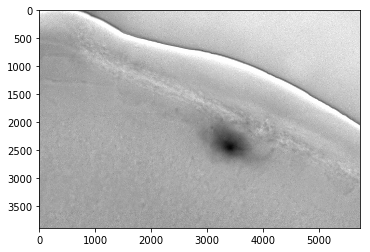

In [0]:
# display original image
import matplotlib.pyplot as plt

# Assuming neuron ID 651806289 has been downloaded, here's a .tif file
a_tiff_file = "/content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.tif"
input_image = Image.open(a_tiff_file)

plt.imshow(input_image, cmap = plt.cm.gray) 
# Need to tell matplotlib.pyplot.imshow how to interpret the 8-bit grayscale
# Otherwise, it will render mono-greenscale

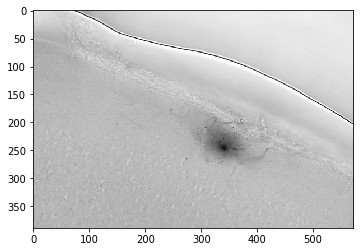

In [0]:
# Display downsampled image:

from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

# Assuming 0001.tif was downsampled as above:
output_file_name = "/content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.downsampled.tif"
downed_image = Image.open(output_file_name)
plt.imshow(downed_image, cmap = plt.cm.gray)
#for i in range(5):
#  clear_output()
#  plt.imshow(randn(28, 28))
#  plt.show()
#  sleep(1)

As you can see from the axis, the image was decimated i.e. downsampled to 1/10 original size: 

(5730, 3890) => (573, 389)

In [0]:
from google.colab import files
from PIL import Image

output_file_name = "/content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.downsampled.tif"

outfile = Image.open(output_file_name)

print( "size: %dx%d" % outfile.size)
files.download(output_file_name) 


size: 573x389


### Decimate whole image stack

Neuron ID 651806289 has 291 TIFF files in its image stack, each image about 22MB, too big for over the web animation of the stack. 

So, reduce each file to 1/100th it's size (1/10 x 1/10 i.e. decimated), down to 223KB per image.

In [0]:
!ls -l /content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-*|wc -l

292


In [0]:
# Downsample a whole image stack

from os import listdir
from os.path import isfile, join

# This assumes neuron ID 651806289's data has already been downloaded
input_directory = "/content/brightfield_challenge_dataset/651806289/"
an_input_file_name = "reconstruction_0_0539044762_644941196-0001.downsampled.tif"
output_directory = "/content/built/downsampled/651806289/"

def decimate_image(image):
    "Processes the image to 1/10 size"
    width, height = image.size
    w = int(width/10)
    h = int(height/10)
    new_image = image.resize((w, h), Image.ANTIALIAS)
    return new_image

if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# https://stackoverflow.com/a/3207973
only_files = [f for f in listdir(input_directory) if isfile(join(input_directory, f))]

for a_file in only_files:   
  if a_file.endswith(".tif"):
    input_name = join(input_directory, a_file)
    output_name = join(output_directory, a_file)

    print("Processing: " + a_file)
    print("  " + input_name)
    print("  " + output_name)
    input_image = Image.open(input_name)
    decimated_image = decimate_image(input_image)
    decimated_image.save(output_name)
  else:
    print("Ignoring: " + a_file)


### Show downsampled image stack


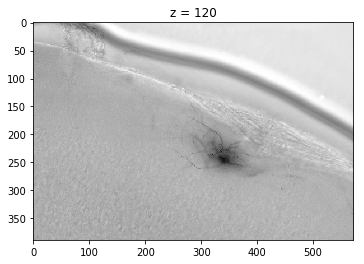

In [0]:
#@title Stack viewer { run: "auto" }

Z = 120 #@param {type:"slider", min:1, max:291, step:1}

import matplotlib.pyplot as plt
from PIL import Image

# Two constants needs to be set:
images_directory = "/content/built/downsampled/651806289/"
file_root = "reconstruction_0_0539044762_644941196-"

z_4_wide = '{:04}'.format(Z)
constructed_name = images_directory + file_root + z_4_wide + ".tif"
                      
downed_image = Image.open(constructed_name)
plt.title("z = " + str(Z))
plt.imshow(downed_image, cmap = plt.cm.gray)


In [0]:
!ls -lah /content/built/downsampled/651806289

In [0]:
# TODO: add progress indicator to above code
# Here's the progess code:



from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


# Set up a progress indicator for this slow task:
progressIndicator = display(progress(0, 100), display_id=True)
progressIndicator_count = 0
progressIndicator_end = 105

for x in something:
  progressIndicator_count += 1
  progressIndicator.update(progress(progressIndicator_count, progressIndicator_end))


In [0]:
# Create animaged slide show running in Colab python
#   via clear_output() and sleep()
# https://stackoverflow.com/a/52866695
#
# Kinda hacky

# One constant needs to be set:
images_directory = "/content/built/downsampled/651806289/"

from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from os import listdir
from os.path import join
from time import sleep

# https://stackoverflow.com/a/3207973
only_files = [f for f in listdir(images_directory) if isfile(join(images_directory, f))]

only_files.sort()

for a_file in only_files:   
  clear_output()
  print(a_file)
  plt.imshow(Image.open(a_file), cmap = plt.cm.gray)
  plt.show()
  sleep(1)

image_stack.gif


FileNotFoundError: ignored

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reconstruction_0_0539044762_644941196-0291.tif


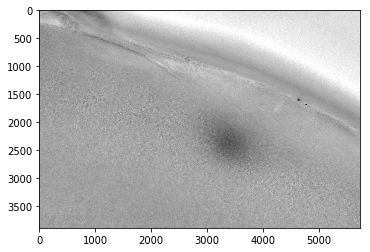

<IPython.core.display.Javascript object>

In [0]:
# Create Slideshow, decimated images already generated: Let's try it via Google's widgets
# https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=P6xc9QVFSlrw

# Still not good enough, very flashy, but at least text below image doesn't jump up and down like first attempt.
# I.e. the google.colab.widgets helped a bit.

from google.colab import widgets
from matplotlib import pylab

# One constant needs to be set:
images_directory = "/content/built/downsampled/651806289/"

from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from time import sleep

# https://stackoverflow.com/a/3207973
only_files = [f for f in listdir(images_directory) if isfile(join(images_directory, f))]

only_files.sort()

# works:
#for a_file in only_files:   
#  clear_output()
#  print(a_file)
#  plt.imshow(Image.open(a_file), cmap = plt.cm.gray)
#  plt.show()
#  sleep(0.5)

  
grid = widgets.Grid(1, 1)
for a_file in only_files:   
  with grid.output_to(0,0):
    grid.clear_cell()
    print(a_file)
    #pylab.figure(figsize=(2, 2))
    #pylab.plot(np.random.random((10, 1)))
    plt.imshow(Image.open(a_file), cmap = plt.cm.gray)
    plt.show()
    sleep(0.5)
    

In [0]:
!ls -lh /content/built/downsampled/651806289/

total 63M
-rw-r--r-- 1 root root 2.3K Oct 15 22:18 reconstruction_0_0539044762_644941196-0001.downsampled.tif
-rw-r--r-- 1 root root 218K Oct 15 22:17 reconstruction_0_0539044762_644941196-0001.tif
-rw-r--r-- 1 root root 218K Oct 15 22:18 reconstruction_0_0539044762_644941196-0002.tif
-rw-r--r-- 1 root root 218K Oct 15 22:17 reconstruction_0_0539044762_644941196-0003.tif
-rw-r--r-- 1 root root 218K Oct 15 22:17 reconstruction_0_0539044762_644941196-0004.tif
-rw-r--r-- 1 root root 218K Oct 15 22:17 reconstruction_0_0539044762_644941196-0005.tif
-rw-r--r-- 1 root root 218K Oct 15 22:18 reconstruction_0_0539044762_644941196-0006.tif
-rw-r--r-- 1 root root 218K Oct 15 22:17 reconstruction_0_0539044762_644941196-0007.tif
-rw-r--r-- 1 root root 218K Oct 15 22:18 reconstruction_0_0539044762_644941196-0008.tif
-rw-r--r-- 1 root root 218K Oct 15 22:18 reconstruction_0_0539044762_644941196-0009.tif
-rw-r--r-- 1 root root 218K Oct 15 22:17 reconstruction_0_0539044762_644941196-0010.tif
-rw-r--r--

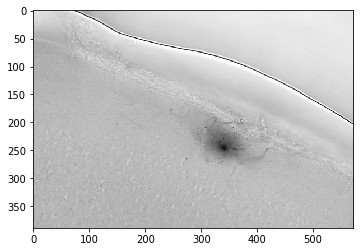

In [0]:
# display one
import matplotlib.pyplot as plt

# Assuming 0001.tif was downsampled as above:
output_file_name = "/content/brightfield_challenge_dataset/651806289/reconstruction_0_0539044762_644941196-0001.downsampled.tif"
downed_image = Image.open(output_file_name)
plt.imshow(downed_image, cmap = plt.cm.gray)

### Make animated GIF


In [0]:
# One constant needs to be set:
images_directory = "/content/built/downsampled/651806289/"


from PIL import Image
import matplotlib.pyplot as plt
from os.path import isfile, join

# https://stackoverflow.com/a/3207973
only_files = [f for f in listdir(images_directory) if isfile(join(images_directory, f))]

only_files.sort()

image_stack = []

for a_file in only_files:   
  image_stack.append(Image.open(join(images_directory, a_file)))  

animation_file_name = join(images_directory, "image_stack.gif")
# https://www.pythoninformer.com/python-libraries/pillow/creating-animated-gif/
image_stack[0].save(animation_file_name,
               format="GIF",
               save_all=True,
               append_images=image_stack[1:],
               duration=50,
               loop=0)

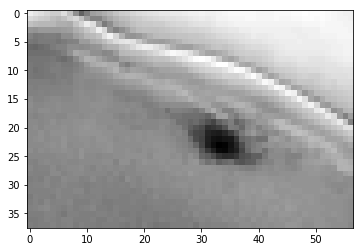

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
file_name = "/content/built/downsampled/651806289/image_stack.gif"
ani_image = Image.open(file_name)
plt.imshow(ani_image, cmap = plt.cm.gray)

In [0]:
from google.colab import files
files.download("/content/built/downsampled/651806289/image_stack.gif") 

In [0]:
from IPython.display import HTML, display
import ipywidgets

animatedGif = "/content/built/downsampled/651806289/image_stack.gif"

file = open(animatedGif , "rb")
image = file.read()
#progress= ipywidgets.Image(
#    value=image,
#    format='gif',
#    width=100,
#    height=100)
display(progress)

Image(value=b'GIF89a9\x00&\x00\x86\x00\x00kkktttxxxyyy\x87\x87\x87\x89\x89\x89\x8d\x8d\x8d\x8e\x8e\x8e\x98\x98…

In [0]:
# Inspect animated gif
# https://pythontic.com/image-processing/pillow/extract%20frames%20from%20animated%20gif
from PIL import Image

animatedGif = "/content/built/downsampled/651806289/image_stack.gif"

imageObject = Image.open(animatedGif)

print(imageObject.is_animated)

print(imageObject.n_frames)

True
292


In [0]:
# TODO: add progress indicator
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


# Set up a progress indicator for this slow task:
animatedGif = "/content/built/downsampled/651806289/image_stack.gif"

file = open(animatedGif , "rb")
image = file.read()
progressor= Image(
    value=image,
    format='gif',
    width=100,
    height=100)





progressIndicator = display(progress(0, 100), display_id=True)
progressIndicator_count = 0
progressIndicator_end = 105

for x in something:
  progressIndicator_count += 1
  progressIndicator.update(progress(progressIndicator_count, progressIndicator_end))


### TIFF to GIF then to animated GIF?


In [0]:
# 2 constants:
tifs_directory = "/content/built/downsampled/651806289/"
gifs_directory = "/content/built/downsampled/651806289/giffed/"

from PIL import Image
import matplotlib.pyplot as plt
from os.path import isfile, join
import os

if not os.path.exists(gifs_directory):
  os.makedirs(gifs_directory)

# https://stackoverflow.com/a/3207973
only_files = [f for f in listdir(tifs_directory) if isfile(join(tifs_directory, f))]

only_files.sort()

for a_file in only_files:
  in_file = join(tifs_directory, a_file)
  outname = os.path.basename(os.path.splitext(a_file)[0]) + ".gif"
  out_file = join(gifs_directory, outname)
  print(out_file)
  an_image = Image.open(in_file)  
  an_image.save(out_file, format="GIF")

/content/built/downsampled/651806289/giffed/image_stack.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0001.downsampled.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0001.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0002.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0003.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0004.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0005.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0006.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0007.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0008.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0009.gif
/content/built/dow

In [0]:
# This loads all files in a dir, that start with reconstruction_0_0539044762_644941196-
# Those 291 files are crammed into an animated GIF
#
# This was made while trying a multiple step process
# 1. decimate tif to tif
# 2. translarte tif to gif
# 3. animate gif
# But maybe that wasn't necessary. Maybe an odd sized file was causing trouble.


# One constant needs to be set:
images_directory = "/content/built/downsampled/651806289/giffed/"


from PIL import Image
import matplotlib.pyplot as plt
from os.path import isfile, join

# https://stackoverflow.com/a/3207973
only_files = [f for f in listdir(images_directory) if isfile(join(images_directory, f))]

only_files.sort()

image_stack = []

for a_file in only_files: 
  if a_file.startswith("reconstruction_0_0539044762_644941196-"):
    print(join(images_directory, a_file))
    image_stack.append(Image.open(join(images_directory, a_file)))  

animation_file_name = join(images_directory, "image_stack.gif")
# https://www.pythoninformer.com/python-libraries/pillow/creating-animated-gif/
image_stack[0].save(animation_file_name,
               format="GIF",
               save_all=True,
               append_images=image_stack[1:],
               duration=50,
               loop=0)

/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0001.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0002.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0003.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0004.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0005.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0006.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0007.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0008.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0009.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0010.gif
/content/built/downsampled/651806289/giffed/reconstruction_0_0539044762_644941196-0011.gif

In [0]:
!ls -lh /content/built/downsampled/651806289/giffed/im*

-rw-r--r-- 1 root root 67M Oct 16 03:16 /content/built/downsampled/651806289/giffed/image_stack.gif


In [0]:
from google.colab import files
files.download("/content/built/downsampled/651806289/giffed/image_stack.gif") 

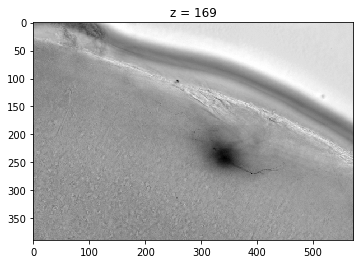

In [0]:
#@title Stack viewer { run: "auto" }

Z = 169 #@param {type:"slider", min:1, max:291, step:1}

import matplotlib.pyplot as plt
from PIL import Image

# Two constants needs to be set:
images_directory = "/content/built/downsampled/651806289/giffed/"
file_root = "reconstruction_0_0539044762_644941196-"

z_4_wide = '{:04}'.format(Z)
constructed_name = images_directory + file_root + z_4_wide + ".gif"
                      
downed_image = Image.open(constructed_name)
plt.title("z = " + str(Z))
plt.imshow(downed_image, cmap = plt.cm.gray)

In [145]:
# http://www.xavierdupre.fr/blog/2016-03-30_nojs.html

def make_video(images, outvid=None, fps=5, size=None,
  is_color=True, format="XVID"):
  """
  Create a video from a list of images.
 
  @param      outvid      output video
  @param      images      list of images to use in the video
  @param      fps         frame per second
  @param      size        size of each frame
  @param      is_color    color
  @param      format      see http://www.fourcc.org/codecs.php
  @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
  The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
  By default, the video will have the size of the first image.
  It will resize every image to this size before adding them to the video.
  """
  from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
  fourcc = VideoWriter_fourcc(*format)
  vid = None
  
  print("About to loop through %d files" % len(images))
  
  for image in images:
    if not os.path.exists(image):
      print("FNFE me")
      raise FileNotFoundError(image)
    img = imread(image)
    if vid is None:
      if size is None:
         size = img.shape[1], img.shape[0]
      vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
    if size[0] != img.shape[1] and size[1] != img.shape[0]:
      img = resize(img, size)
    vid.write(img)
  vid.release()
  return vid
 
# One constant needs to be set:
images_directory = "/content/built/downsampled/651806289/"

from PIL import Image
import matplotlib.pyplot as plt
from os.path import isfile, join

# https://stackoverflow.com/a/3207973
only_files = [f for f in listdir(images_directory) if isfile(join(images_directory, f))]

only_files.sort()

image_stack = []
for a_file in only_files: 
  if a_file.startswith("reconstruction_0_0539044762_644941196-"):
    #print(join(images_directory, a_file))
    image_stack.append(join(images_directory, a_file))  

    
movie_name = join(images_directory, "image_stack.mp4")
print("wha?")
make_video(image_stack, outvid=movie_name)  

wha?
About to loop through 292 files


<VideoWriter 0x7f93d30a3f30>

In [146]:
!ls -l /content/built/downsampled/651806289/im*

-rw-r--r-- 1 root root 69072388 Oct 16 02:21 /content/built/downsampled/651806289/image_stack.gif
-rw-r--r-- 1 root root    21364 Oct 16 03:56 /content/built/downsampled/651806289/image_stack.mp4


In [0]:
from google.colab import files
files.download("/content/built/downsampled/651806289/image_stack.mp4")